# Prof. Keller's Method Fit

- Produce replicas by varying F within errF from data (set 0)
- Perform fits to all replicas and obtain a distribution of CFFs
- Determine the mean and sigma of CFFs
- Using the mean, sigma of CFFs and varying kinematics, produce F values using the function(Note: the range of kinematics shouldn't exceed the values of next data set)
- Build a new ANN model with the data generated in (4) -- Inputs: Kinematics & F / Outputs: CFFs
- Produce samples of F varying within errF from the initial data and combine with initial kinematics
- Feed the samples (from 6) to the ANN model built in (5) -- Output: a distribution of CFFs


In [3]:
%load_ext autoreload
%autoreload 2

In [15]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from sklearn.preprocessing import MinMaxScaler

from BHDVCStf import BHDVCS #modified bhdvcs file
import utilities as uts

## Setup

In [5]:
numSets = 15
numReplicas = 500

df = pd.read_csv("dvcs_xs_newsets_genCFFs.csv")
data = uts.DvcsData(df)

In [20]:
localFits = np.fromfile('replicas500.txt')
localFits = replicas.reshape(numSets, numReplicas, 3)

## Generate Pseudo-Data

In [59]:
df

,#Set,index,k,QQ,x_b,t,phi_x,F,errF,F1,F2,dvcs,ReH,ReE,ReHtilde
0,0,0,3.75,1.74013,0.435095,-0.380868,0,0.058205,0.002910,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
1,0,1,3.75,1.74013,0.435095,-0.380868,10,0.055596,0.002780,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
2,0,2,3.75,1.74013,0.435095,-0.380868,20,0.066353,0.003318,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
3,0,3,3.75,1.74013,0.435095,-0.380868,30,0.068655,0.003433,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
4,0,4,3.75,1.74013,0.435095,-0.380868,40,0.072765,0.003638,0.498060,0.68579,0.012288,13.0554,-53.0554,7.25302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
535,14,31,7.75,2.63258,0.345012,-0.361188,310,0.023981,0.001199,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
536,14,32,7.75,2.63258,0.345012,-0.361188,320,0.025345,0.001267,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
537,14,33,7.75,2.63258,0.345012,-0.361188,330,0.024191,0.001210,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283
538,14,34,7.75,2.63258,0.345012,-0.361188,340,0.020530,0.001027,0.512913,0.71481,0.012288,11.7411,-51.7411,6.52283


In [90]:
class step3sim(object):
    def __init__(self, X, replicas, whichSet, numSamples=10000):
        # sample range of 10,000, with replicas repeated and appended to fill
        
        self.X = X
        self.cffs = replicas[whichSet, :, :] # 2d numpy array of shape (replicas, cffs)
        self.whichSet = whichSet        
        self.numSamples = numSamples
        
        self.kins = X.loc[whichSet*36, ['k', 'QQ', 'x_b', 't']] #pandas array of kins for set
        self.dvcs = X.loc[whichSet*36, 'dvcs']
            
    
    def _getKinRange(self, whichKin):
        '''
        :param whichKin: which kinematic to compute range for
        
        :returns: [low end of range, high end of range]
        '''
        krange = np.unique(self.X[whichKin].sort_values())
        idx = np.where(krange == self.kins[whichKin])[0][0]
        
        if idx == 0:  # if kin is lowest, then use for low end (kin - (high - kin) = 2*kin - high)
            return [self.kins[whichKin]*2 - krange[idx + 1], krange[idx + 1]]
        elif idx == (len(krange) - 1):   # if kin is highest, then use for high end (kin + (kin - low) = 2*kin - low)
            return [krange[idx - 1], 2*self.kins[whichKin] - krange[idx - 1]]
        else:
            return [krange[idx - 1], krange[idx + 1]]


    
    def addFs(self, sd):
        '''
        :param sd: dataframe with all necessary variables from which F can be computed
        
        :returns: same dataframe but with F column added
        '''
        bhdvcs = BHDVCS()
        sd['F'] = bhdvcs.TotalUUXS(np.array(sd[['phi_x', 'k', 'QQ', 'x_b', 't', 'F1', 'F2', 'dvcs']]),
                                  np.array(sd['ReH']), np.array(sd['ReE']), np.array(sd['ReHtilde']))
        return sd    

    
    def getSimData(self):
        to_ret = {key: [] for key in self.X.columns} # compose dataframe with each necessary variable
        
        for kin in ['k', 'QQ', 'x_b', 't']: # uniformly sample from kin range for each kinematic
            lohi = self._getKinRange(kin)
            to_ret[kin] = np.random.uniform(lohi[0], lohi[1], self.numSamples)
        
        to_ret['F1'] = uts.f1_f2.ffF1(to_ret['t'])
        to_ret['F2'] = uts.f1_f2.ffF1(to_ret['t'])
                                

        for i, cff in enumerate(['ReH', 'ReE', 'ReHtilde']): # normally sample cffs using local sets to parameterize
            #can also be uniform 
            to_ret[cff] = np.random.normal(self.cffs[:, i].mean(), self.cffs[:, i].std(), size=self.numSamples)

        
        to_ret['dvcs'] = np.repeat(self.dvcs, self.numSamples)
        
        phis = np.repeat(np.linspace(0, 350, 36), self.numSamples//36 + 1)
        to_ret['phi_x'] = phis[:self.numSamples]
        
        sd = pd.DataFrame(to_ret)
        sd = self.addFs(sd)
        return sd
    

In [91]:
t = step3sim(data.X, localFits, 0, 537)
test = t.getSimData()

In [93]:
(test['F'] < 0).mean()

0.19366852886405958

In [69]:
np.unique(data.X['k'])

array([3.75, 4.75, 5.75, 6.75, 7.75])

In [67]:
test

[2.75, 4.75]

In [94]:
def fit_pred_kinSet(whichSet, data, localFits, numReplicas):
    
    s3 = step3sim(data.X, localFits, whichSet)
    locData = s3.getSimData()
    
    locData = locData.dropna() # some F values are NA
    
    rescaler = MinMaxScaler()
    rescaler = rescaler.fit(locData[['k', 'QQ', 'x_b', 't', 'F']])
    X = rescaler.transform(locData[['k', 'QQ', 'x_b', 't', 'F']])
    y = locData[['ReH', 'ReE', 'ReHtilde']]
    
    
    model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(20, input_shape=(5,), activation="elu", kernel_initializer="he_normal"),
    tf.keras.layers.Dense(20, activation="elu", kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3)
    ])
    
    model.compile(
    optimizer = tf.keras.optimizers.Nadam(.01),
    loss = tf.keras.losses.MeanSquaredError()
    )
    
    model.fit(X, y, epochs=100, verbose=0)
        

    #to_pred = np.tile(np.array(data.Kinematics.loc[whichSet*36 + 18, :]), (100, 1)) 

    to_pred = pd.concat([data.Kinematics.loc[[whichSet*36 + 18], :] for _ in range(numReplicas)]) #phi=180
    to_pred['F'] = [data.getSet(whichSet).sampleY()[18] for _ in range(numReplicas)] #phi=180
    
    to_pred = rescaler.transform(to_pred)
    
    #yhat = np.stack([model(to_pred, training=True) for sample in range(100)]).reshape()
    
    return model.predict(to_pred)

In [95]:
def produceResults(data, localFits, numSets, numReplicas):
    '''
    data: a tensorflow neural network model
    X: [standardized kins, xnocff]
    orig_weights: the original weights from when the model was created (used to reset model after it has been trained)
    numSets: the number of kinematic sets
    numReplicas: the number of replicas
    
    returns: np array of cff predictions of shape (numSets, numReplicas, numCFFs)
    '''
    by_set = []
    for i in tqdm(range(numSets)):
        by_set.append(fit_pred_kinSet(i, data, localFits, numReplicas).tolist())

    return np.array(by_set)

In [96]:
results = produceResults(data, localFits, numSets, numReplicas)

# ReH

In [101]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 0)

Mean percent error:  10.093974967524725
RMSE:  0.9950933731879564
RMSE w yhat=mean:  2.5254628436780107
R-squared:  0.84474496208628


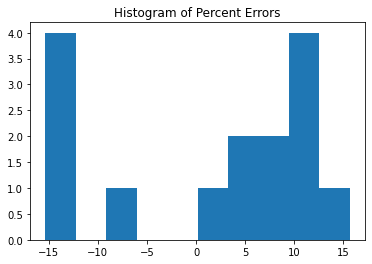

In [102]:
uts.evaluate(y_yhat)

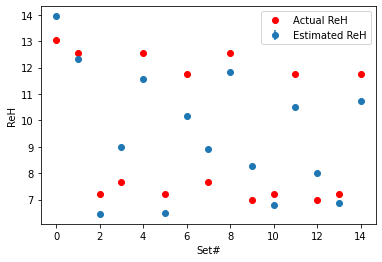

In [103]:
uts.plotError(y_yhat, err, "ReH")

# ReE

Mean percent error:  9.810335247780294
RMSE:  5.127705676291191
RMSE w yhat=mean:  2.525480507907797
R-squared:  -3.1224760074685625


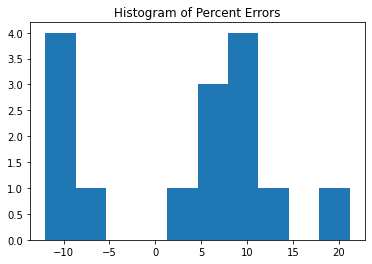

In [104]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 1)
uts.evaluate(y_yhat)

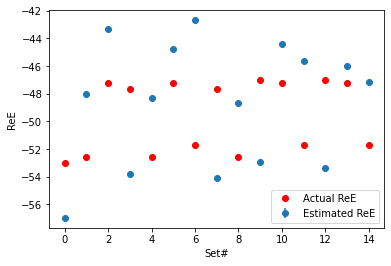

In [105]:
uts.plotError(y_yhat, err, "ReE")

In [111]:
np.unique(data.X['t'])

array([-0.380868, -0.373495, -0.361188, -0.291599, -0.283318, -0.27869 ])

# ReHtilde

Mean percent error:  7.8495327738820215
RMSE:  0.4109572456244328
RMSE w yhat=mean:  1.4030345621243816
R-squared:  0.914206073422545


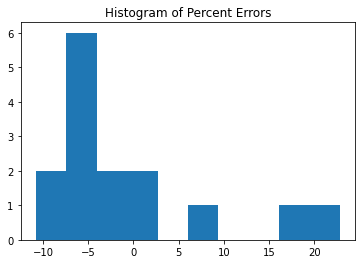

In [106]:
y_yhat, err = uts.y_yhat_errCFFs(data, results, 2)
uts.evaluate(y_yhat)

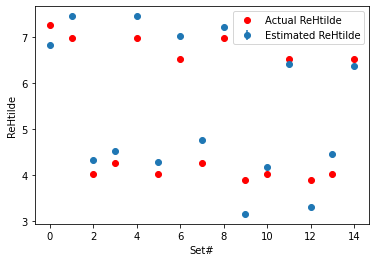

In [107]:
uts.plotError(y_yhat, err, "ReHtilde")

# Propagated Fs at 180

Use the compton form factors as inputs to TotalUUXS to estimate the distribution of F, then compare it with the baseline.

Mean percent error:  5.838882614414955
RMSE:  0.002121416218278457
RMSE w yhat=mean:  0.015855649879790133
R-squared:  0.9820987369274686


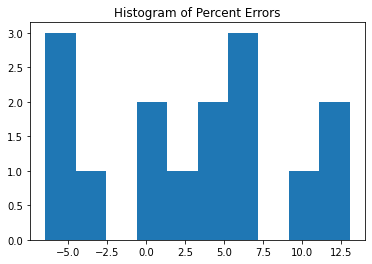

In [108]:
y_yhat, err = uts.y_yhat_errFs(results, data)
uts.evaluate(y_yhat)

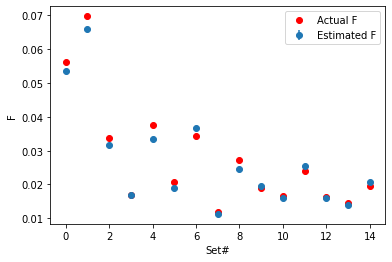

In [109]:
uts.plotError(y_yhat, err, "F")